# <span style="color:orange"> Exercise 12.1 </span>
## <span style="color:green"> Task </span>

By keeping fixed all the other parameters, try to use at least two other optimizers, different from SGD. <span style="color:red">Watch to accuracy and loss for training and validation data and comment on the performances</span>.

## <span style="color:green"> Solution </span>
To complete the exercise, I decided to test the model with a few different optimizers, in order to test the performance of each. The ```run``` funtion parses and organizes the dataset so that it can be read by a keras model. Then, a Sequential model is defined with 400 input neurons, 100 nodes in the first hidden layer, a dropout layer with rate 0.5 and an output layer with 10 nodes, matching the number of possible digits to be predicted. The model presents an input layer with 400 nodes, which represents a number close to the half of the input pixels (image size) of an image (http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf). A hidden layer is present because of the non-linearity of the problem, while a number of 100 neurons have been chosen in order to 

In [3]:
import sys, os
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('INFO')
from dataclasses import dataclass
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, optimizers, losses, utils
from keras.datasets import mnist
import tabulate

@dataclass
class Result:
    model : keras.models.Model
    optimizer : keras.optimizers.Optimizer
    loss_score : float
    accuracy_score : float
        
    def __getitem__(self,key:str):
        val = exec(f"self.{key}")
        return val
    
    def values(self):
        return self.__dict__.values()

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)
iter=0
results = []

def run(opt):
    """
    [RUN]
    Training simulation
    1. Split mnist database into training data and testing data
    2. Reshape the data
    3. Normalize data (bring values from a range in [0,255] to values in range [0,1])
    4. Define and compile the model
    5. Fit the model
    """
    
    global iter
    print(f"---> Running iteration {iter} with optimizer {opt.__class__.__name__}")
    # input image dimensions
    img_rows, img_cols = 28, 28 # number of pixels 
    # output
    num_classes = 10 # 10 digits

    # the data, split between train and test sets
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    print('X_train shape:', X_train.shape)
    print('Y_train shape:', Y_train.shape)
    print()
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    # reshape data, it could depend on Keras backend
    X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

    # cast floats to single precesion
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # Normalize -> rescale data in interval [0,1]
    X_train /= 255
    X_test /= 255
    

    # Preview -> look at an example of data point
    print('an example of a data point with label', Y_train[20])
    # matshow: display a matrix in a new figure window
    plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
    plt.show()
    print('an example of a data point with label', Y_train[20], 'before to_categorical ...')
    # convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
    Y_train = keras.utils.to_categorical(Y_train, num_classes)
    Y_test = keras.utils.to_categorical(Y_test, num_classes)
    print('... and with label', Y_train[20], 'after to_categorical')
    print()
    print('X_train shape:', X_train.shape)
    print('Y_train shape:', Y_train.shape)
    print('X_test shape:', X_test.shape)
    print('Y_test shape:', Y_test.shape)
    
    # Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
    labels = np.array([0, 2, 1, 2, 0])
    # `to_categorical` converts this into a matrix with as many columns as there are classes.
    # The number of rows stays the same.
    keras.utils.to_categorical(labels)
    
    def create_DNN():
        # instantiate model
        model = models.Sequential()
        # add a dense all-to-all relu layer
        model.add(layers.Dense(img_rows*img_cols,input_shape=(img_rows*img_cols,), activation='relu'))
        model.add(layers.Flatten())
        # add a dense all-to-all relu layer
        model.add(layers.Dense(100, activation='relu'))
        # apply dropout with rate 0.5
        model.add(layers.Dropout(0.5))
        # soft-max layer
        model.add(layers.Dense(num_classes, activation='softmax'))

        return model

    def compile_model(opt):
        # create the model
        model=create_DNN()
        # compile the model
        model.compile(loss=losses.CategoricalCrossentropy(),
                      optimizer=opt,
                      metrics=['accuracy'])
        return model

    # training parameters
    batch_size = 64
    epochs = 100

    # create the deep neural net
    model_DNN = compile_model(opt)

    # train DNN and store training info in history
    print("Training data with size (",X_train.shape,",",Y_train.shape,")")
    print("Test data size  (",X_test.shape,",",Y_test.shape,")")
    history = model_DNN.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(X_test, Y_test))
    
    # evaluate model
    score = model_DNN.evaluate(X_test, Y_test, verbose=1)

    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # look into training history

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('model accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    
    #X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
    predictions = model_DNN.predict(X_test)

    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

    plt.figure(figsize=(15, 15)) 
    for i in range(10):    
        ax = plt.subplot(2, 10, i + 1)    
        plt.imshow(X_test[i, :, :, 0], cmap='gray')    
        plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
        plt.axis('off') 
    plt.show()
    iter+=1
    res = Result(model_DNN,opt.__class__.__name__,score[0],score[1])
    results.append(res)
    print("\n\n")

---> Running iteration 0 with optimizer SGD
X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples
an example of a data point with label 4


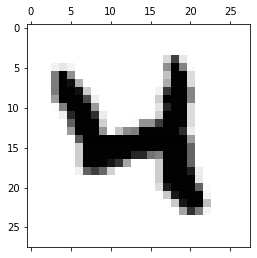

an example of a data point with label 4 before to_categorical ...
... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)
X_test shape: (10000, 784)
Y_test shape: (10000, 10)
Training data with size ( (60000, 784) , (60000, 10) )
Test data size  ( (10000, 784) , (10000, 10) )
313/313 [==============================] - 0s 454us/step - loss: 0.0557 - accuracy: 0.9834

Test loss: 0.05573297291994095
Test accuracy: 0.9833999872207642


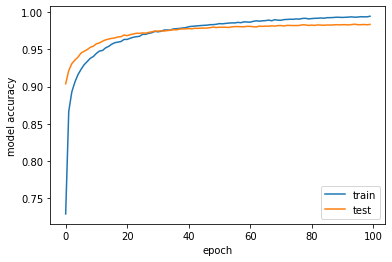

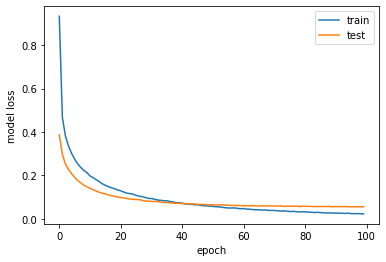

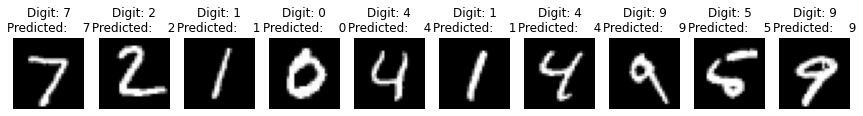




---> Running iteration 1 with optimizer Adam
X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples
an example of a data point with label 4


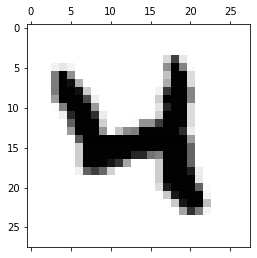

an example of a data point with label 4 before to_categorical ...
... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)
X_test shape: (10000, 784)
Y_test shape: (10000, 10)
Training data with size ( (60000, 784) , (60000, 10) )
Test data size  ( (10000, 784) , (10000, 10) )
313/313 [==============================] - 0s 466us/step - loss: 0.2721 - accuracy: 0.9815

Test loss: 0.2720712423324585
Test accuracy: 0.9815000295639038


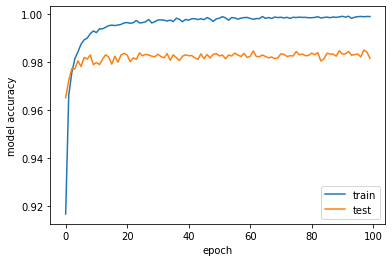

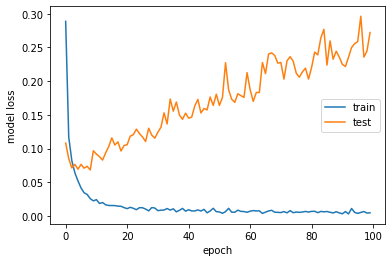

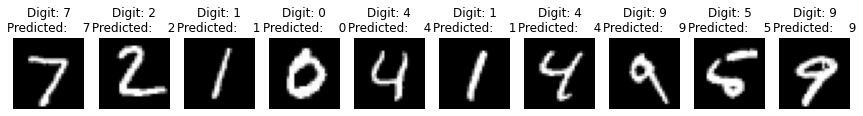




---> Running iteration 2 with optimizer Adagrad
X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples
an example of a data point with label 4


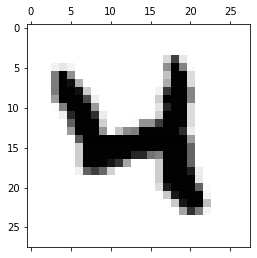

an example of a data point with label 4 before to_categorical ...
... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)
X_test shape: (10000, 784)
Y_test shape: (10000, 10)
Training data with size ( (60000, 784) , (60000, 10) )
Test data size  ( (10000, 784) , (10000, 10) )
313/313 [==============================] - 0s 466us/step - loss: 0.1181 - accuracy: 0.9637

Test loss: 0.11812077462673187
Test accuracy: 0.963699996471405


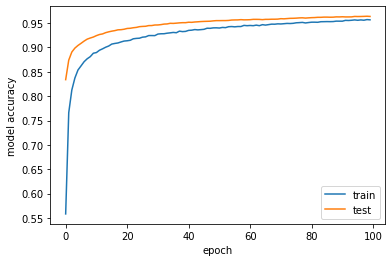

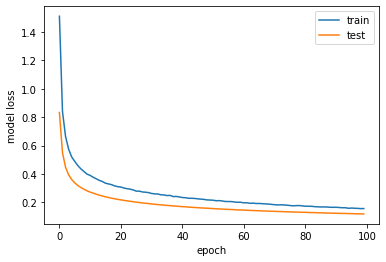

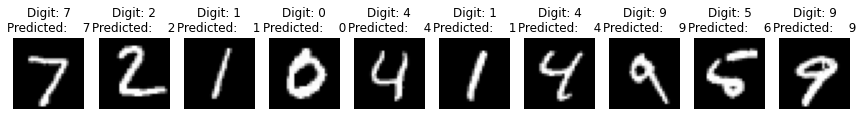




---> Running iteration 3 with optimizer Nadam
X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples
an example of a data point with label 4


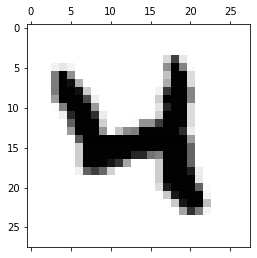

an example of a data point with label 4 before to_categorical ...
... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)
X_test shape: (10000, 784)
Y_test shape: (10000, 10)
Training data with size ( (60000, 784) , (60000, 10) )
Test data size  ( (10000, 784) , (10000, 10) )
313/313 [==============================] - 0s 449us/step - loss: 0.2410 - accuracy: 0.9851

Test loss: 0.24103957414627075
Test accuracy: 0.9850999712944031


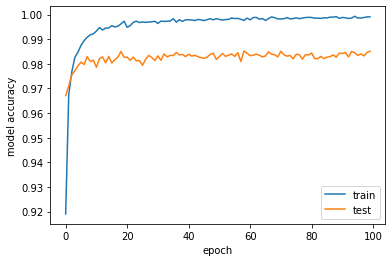

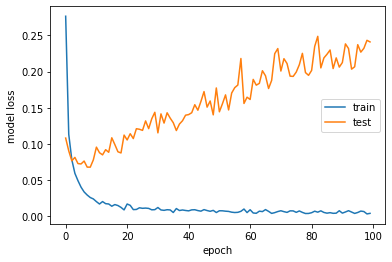

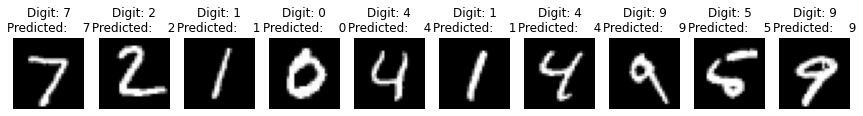

In [4]:
opts = [
    optimizers.SGD(),
    optimizers.Adam(),
    optimizers.Adagrad(),
    optimizers.Nadam()
]

for index,o in enumerate(opts):
    run(o)

In [5]:
table = [list(res.values())[1:] for res in results]
print(tabulate.tabulate(table,headers=["Optimizer","Loss Score","Accuracy Score"]))

Optimizer      Loss Score    Accuracy Score
-----------  ------------  ----------------
SGD              0.055733            0.9834
Adam             0.272071            0.9815
Adagrad          0.118121            0.9637
Nadam            0.24104             0.9851


In [18]:
sequence = [x.accuracy_score for x in results]
best = next(res for res in results if res.accuracy_score == max(sequence))
worst = next(res for res in results if res.accuracy_score == min(sequence))
print("Optimizer with highest accuracy score ",best.optimizer," with score ",best.accuracy_score)
print("Optimizer with lowest accuracy score ",worst.optimizer," with score ",worst.accuracy_score)

Optimizer with highest accuracy score  Nadam  with score  0.9804999828338623
Optimizer with lowest accuracy score  Adagrad  with score  0.9190000295639038


## <span style="color:green"> Results </span>
Optimizers are algorithms or methods used to change the attributes of the neural network such as weights and learning rate in response to the output of the loss function, in order to reduce this value. There are various algorithms that may perform this job, but only a few have been chosen for this task:

#### Gradient Descent
By far the most simple and popular algorithm, it is most commonly used in linear regressions and classification problems, such as the current one.<br>
It works as follows:
1. Calculate what a small change in each individual weight would do to the loss function (i.e. which direction should the hiker walk in)
2. Adjust each individual weight based on its gradient (i.e. take a small step in the determined direction)
3. Keep doing steps #1 and #2 until the loss function gets as low as possible.

<img src="../media/images/gradient_descent.jpeg" alt="Gradient Descent">

Gradient descent is easy to implement and easy to understand, however one may find an impasse by getting stuck on a local minima and never reach the global one. 

#### Adam
Adam (Adaptive Moment Estimation) is a method for efficient stochastic optimization that only requires first-order gradients with little memory requirement. Adam joins the advantages of two common SGD extensions — Root Mean Square Propagation (RMSProp) and Adaptive Gradient Algorithm (AdaGrad) — and computes individual adaptive learning rates for different parameters.

#### Nadam
Adam can be viewed as a combination of RMSprop and and AdaGrad, while Nadam can be viewed as a combination of Adam and NAG (Nesterov accelerated gradient). The incorporation of NAG into Adam is done by modifying the momentum term $m_t$ which accounts for the exponentially decaying average of past gradients for the Adam algorithm. 

#### Adagrad
Adaptive Gradient Algorithm (Adagrad) is an algorithm for gradient-based optimization. It performs smaller updates therefore it is well-suited when dealing with sparse data (NLP or image recognition). Each parameter has its own learning rate that improves performance on problems with sparse gradients, so the algorithm adaptively scales the learning rate for each dimension. 



In [6]:
## saving model with best score
from operator import attrgetter
model = max(results, key=attrgetter('accuracy_score'))
print(model)
model.model.save("dnn_model/")

Result(model=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fcf940428b0>, optimizer='Nadam', loss_score=0.24103957414627075, accuracy_score=0.9850999712944031)


2021-09-20 16:39:23.408178: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dnn_model/assets
